(720, 1280, 3)


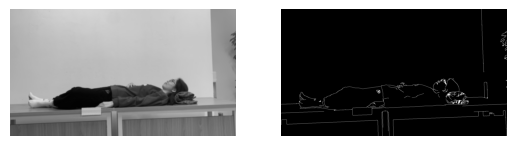

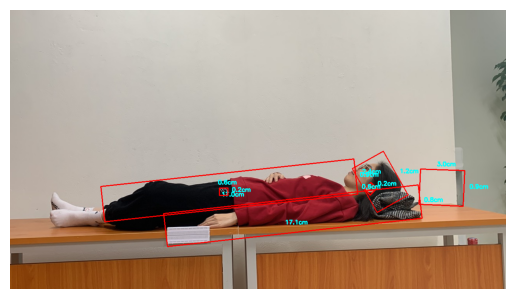

In [6]:
from scipy.spatial.distance import euclidean
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt  # Thêm import

# Function to show array of images (intermediate results)
def show_images(images):
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

img_path = '/home/duong/git/Biomechanics/dataset/patient_2_bouding_box/02.jpg'

# Read image and preprocess
image = cv2.imread(img_path)
print(image.shape)

# Lấy chiều cao của ảnh
height = image.shape[0]

# # Cắt 1/5 ở phía trên, giữ lại phần giữa và 1/3 ở phía dưới
# top_cut = int(1/5 * height)
# bottom_cut = int(3/4 * height)
# image = image[top_cut:bottom_cut, :]

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

show_images([blur, edged])

# Các bước tiếp theo của mã của bạn không thay đổi...


# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Sort contours from left to right as leftmost contour is reference object
(cnts, _) = contours.sort_contours(cnts)

# Remove contours which are not large enough
cnts = [x for x in cnts if cv2.contourArea(x) > 100]

# Reference object dimensions
# Here for reference, I have used a 17cm x 6.3cm object
ref_object = cnts[0]
box = cv2.minAreaRect(ref_object)
box = cv2.boxPoints(box)
box = np.array(box, dtype="int")
box = perspective.order_points(box)
(tl, tr, br, bl) = box
dist_in_pixel = euclidean(tl, tr)

# Change the reference object dimensions
ref_width_cm = 17
ref_height_cm = 6.3

pixel_per_cm_width = dist_in_pixel / ref_width_cm
pixel_per_cm_height = dist_in_pixel / ref_height_cm


# Draw remaining contours
for cnt in cnts:
    box = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    box = perspective.order_points(box)
    (tl, tr, br, bl) = box
    cv2.drawContours(image, [box.astype("int")], -1, (0, 0, 255), 2)
    mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
    mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
    wid = euclidean(tl, tr) / pixel_per_cm_width
    ht = euclidean(tr, br) / pixel_per_cm_height

    cv2.putText(image, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
    cv2.putText(image, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# Hiển thị hình ảnh cuối cùng sử dụng matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()